In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs 

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


## Specify dataset

In [150]:
num_steps = 5000
num_states = 121
input = inputs.Sim2DLevyFlight(
    num_steps=num_steps,
    walls=10,
    alpha=2,
    beta=1
    )

# input = inputs.Sim2DWalk(
#     num_steps=num_steps,
#     num_states=num_states
#     )

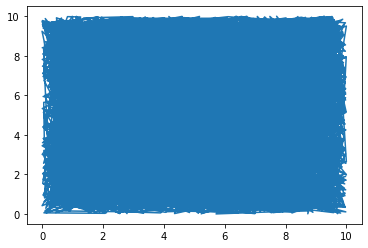

In [151]:
plt.figure();
plt.plot(input.xs, input.ys)
plt.show()

## Specify model you want to test

In [159]:
model_path = '../trained_models/longer_gamma/'
model_file = model_path + 'model.pt'
configs_file = model_path + 'net_configs.p'

if os.path.isfile(configs_file):
    with open(configs_file, 'rb') as f:
        net_configs = pickle.load(f)
    net = STDP_SR(
        num_states=num_states, gamma=net_configs['gamma'],
        ca3_kwargs=net_configs['ca3_kwargs']
        )
else:
    net = STDP_SR(num_states=num_states, gamma=0.9)
    
net.load_state_dict(torch.load(model_file))
net.ca3.set_differentiability(False) 

In [160]:
dg_inputs = torch.from_numpy(input.dg_inputs.T).float().to(device).unsqueeze(1)
dg_modes = torch.from_numpy(input.dg_modes.T).float().to(device).unsqueeze(1)
with torch.no_grad():
    _, outputs = net(dg_inputs, dg_modes, reset=True)
    rnn_T = net.ca3.get_T().detach().numpy()
    est_T = net.ca3.get_ideal_T_estimate()
    error = np.mean(np.abs(est_T - rnn_T))
    print(f'Error at last timestep: {error}')

Error at last timestep: 0.0007244083189084381


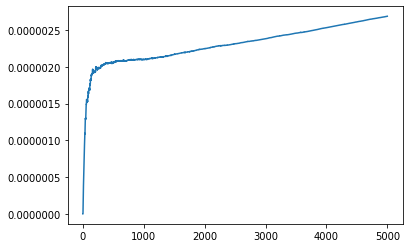

In [161]:
plt.figure()
plt.plot(errors)
plt.show()

## Plot outputs

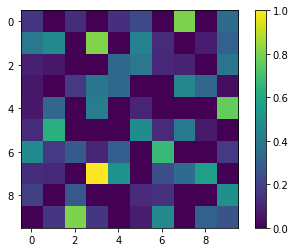

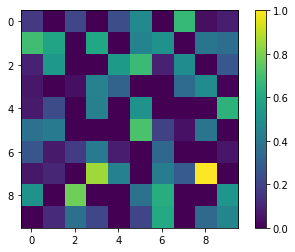

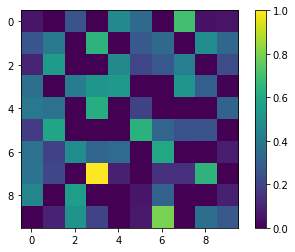

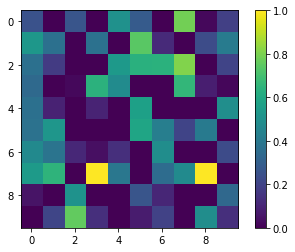

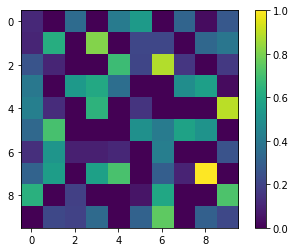

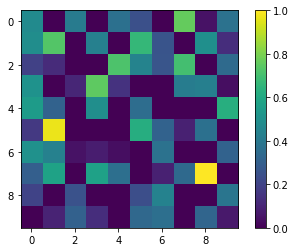

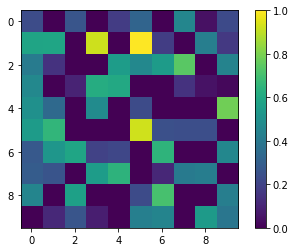

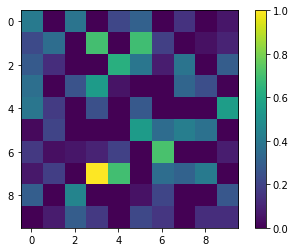

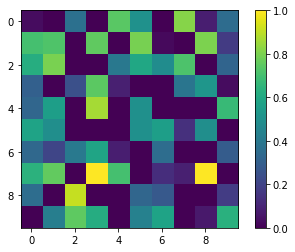

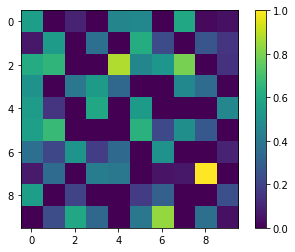

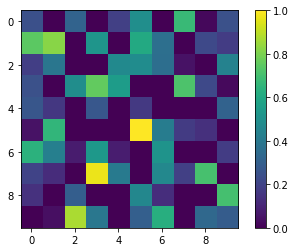

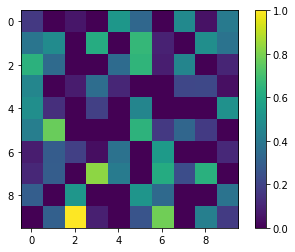

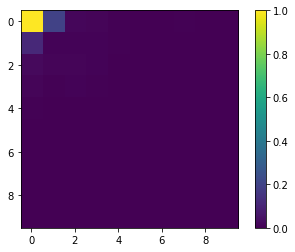

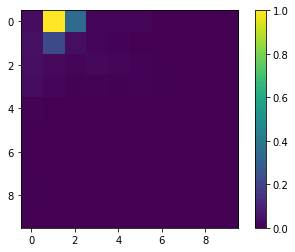

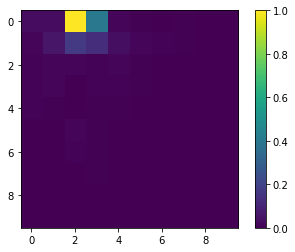

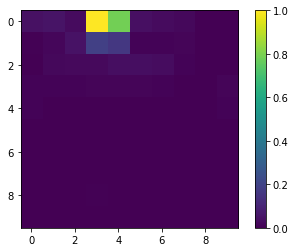

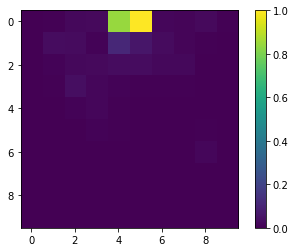

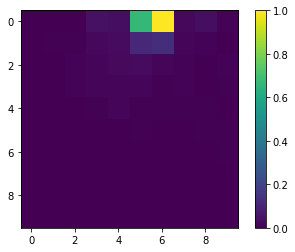

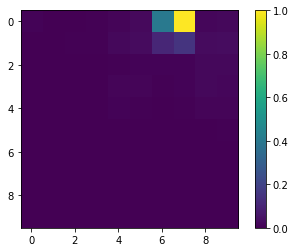

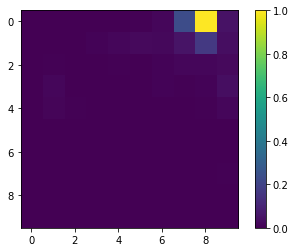

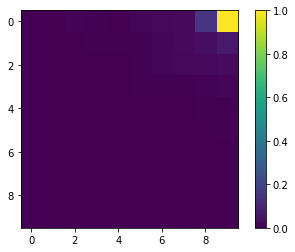

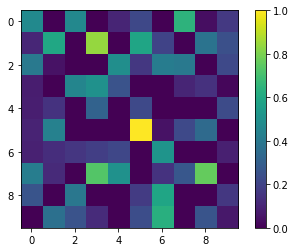

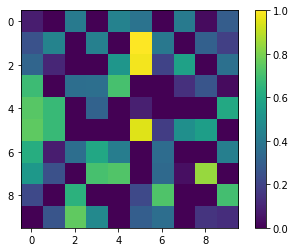

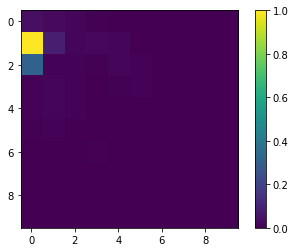

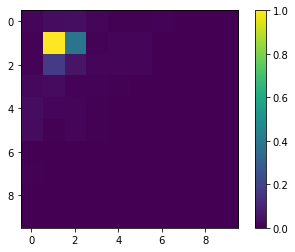

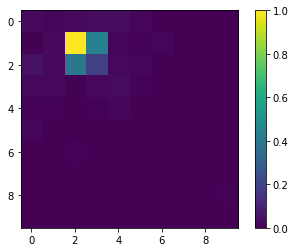

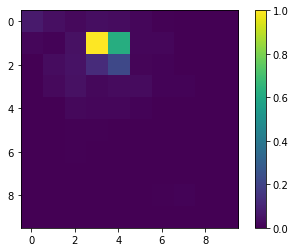

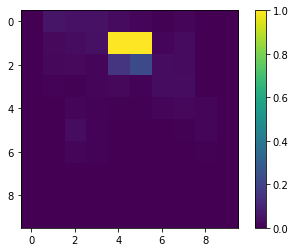

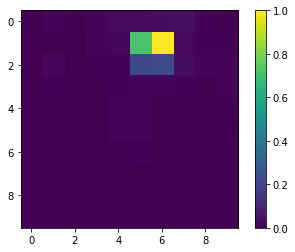

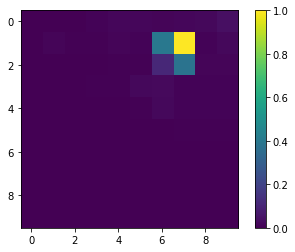

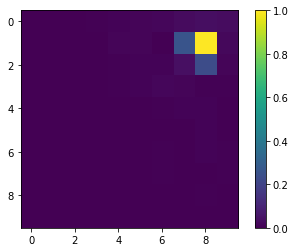

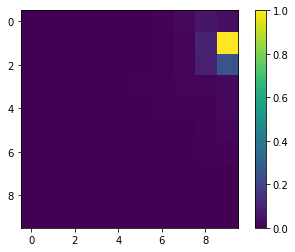

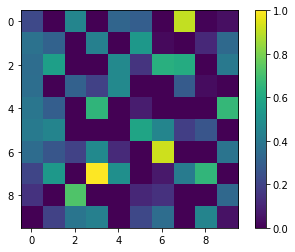

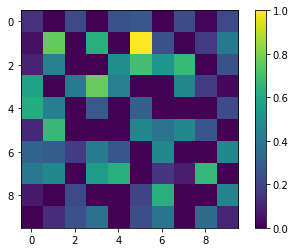

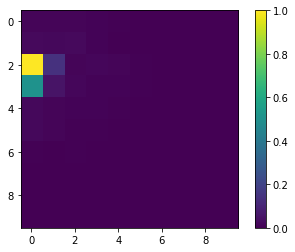

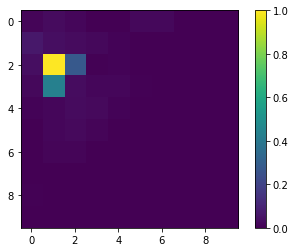

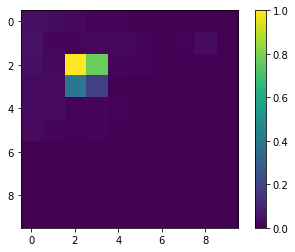

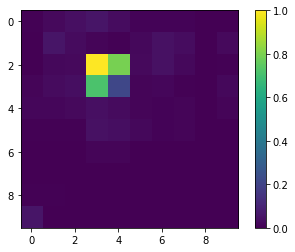

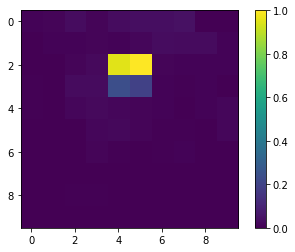

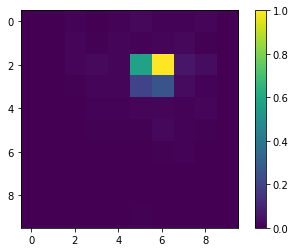

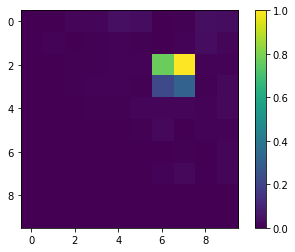

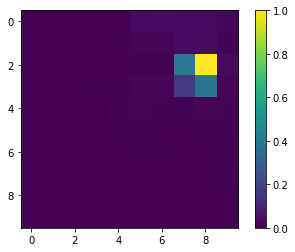

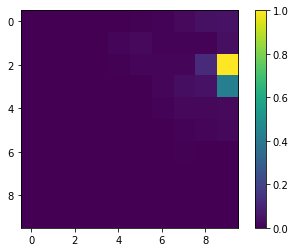

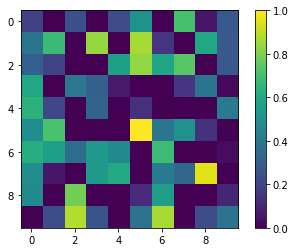

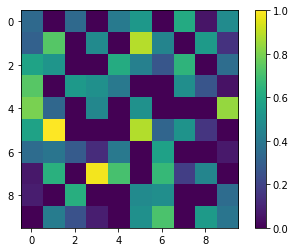

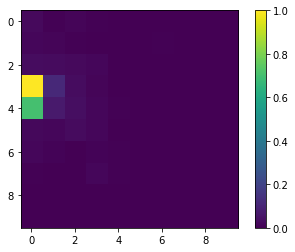

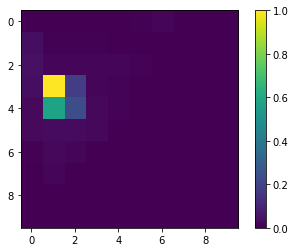

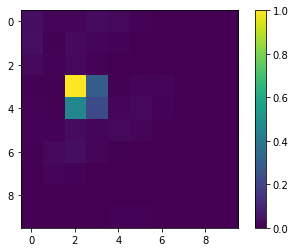

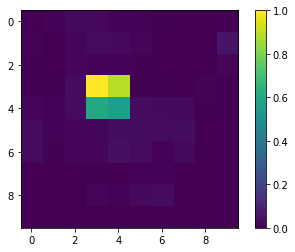

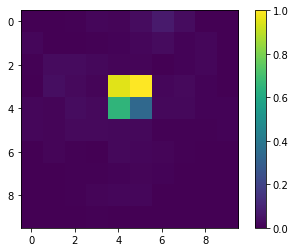

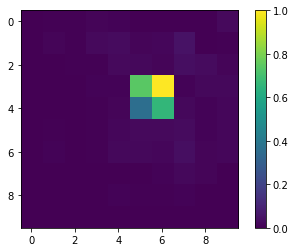

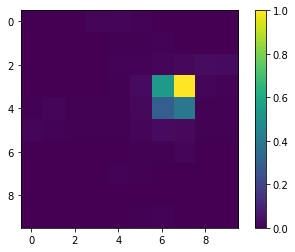

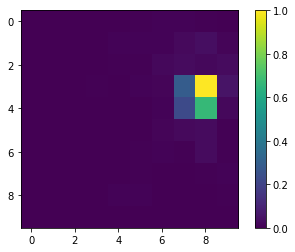

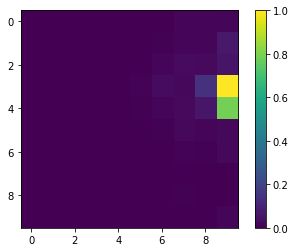

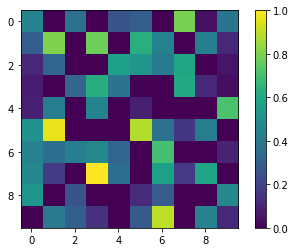

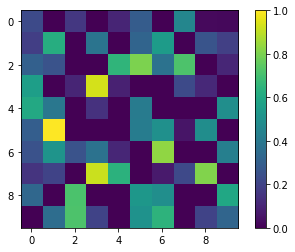

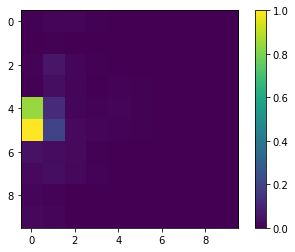

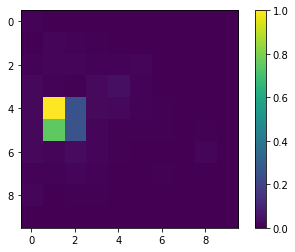

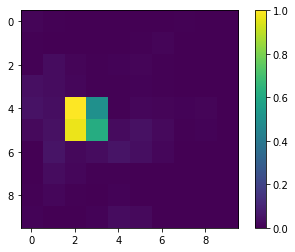

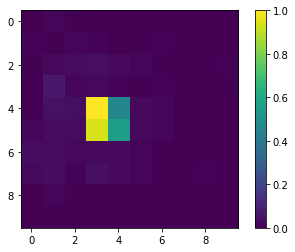

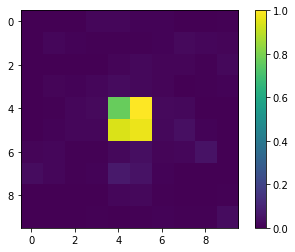

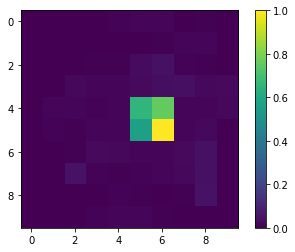

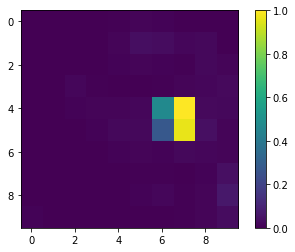

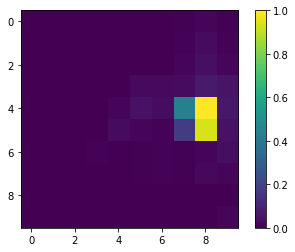

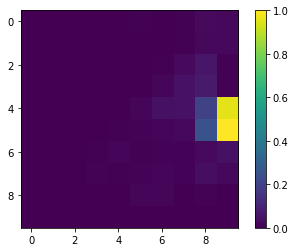

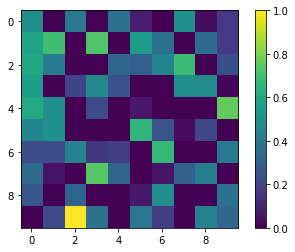

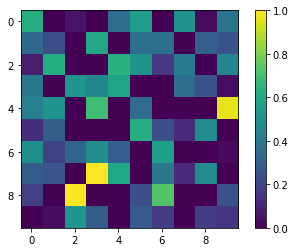

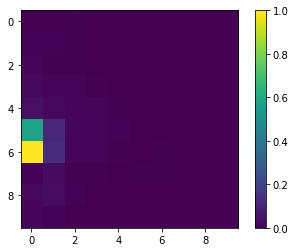

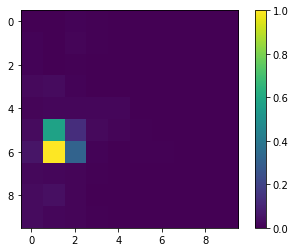

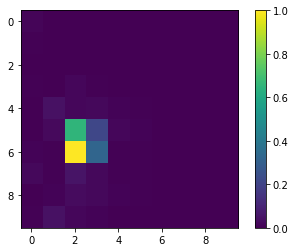

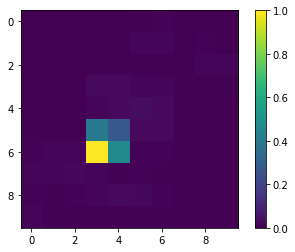

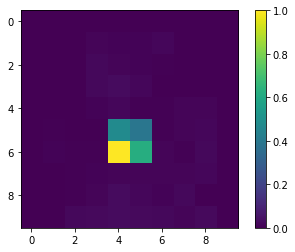

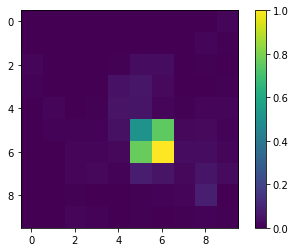

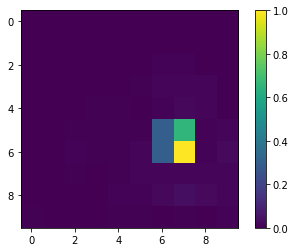

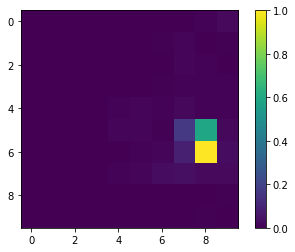

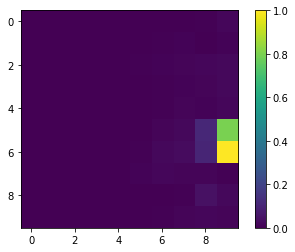

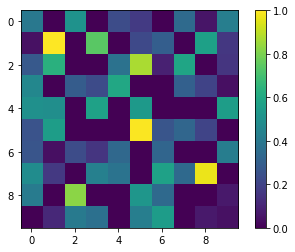

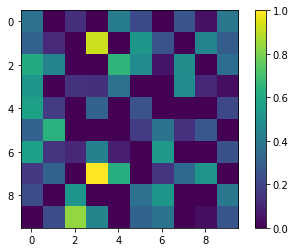

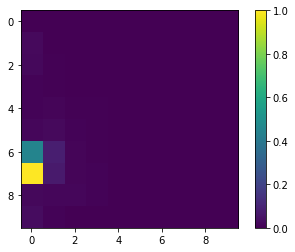

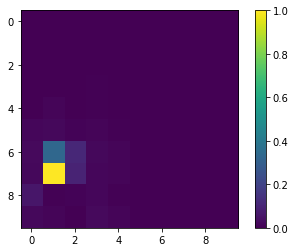

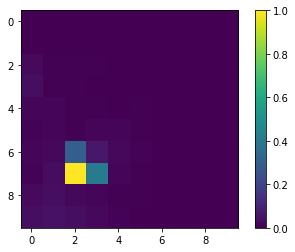

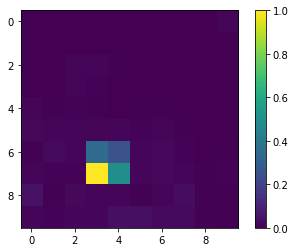

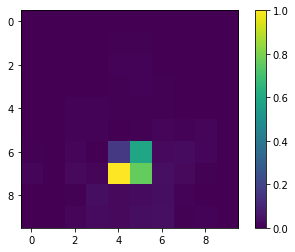

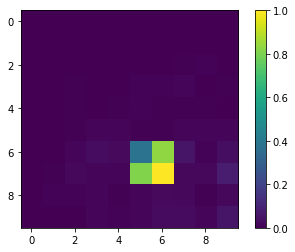

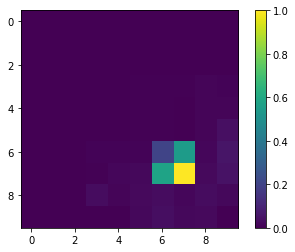

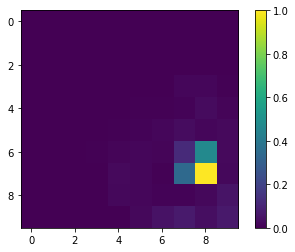

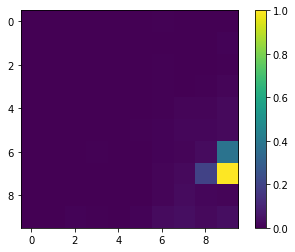

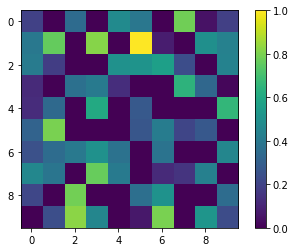

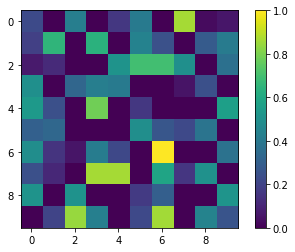

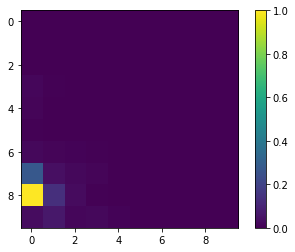

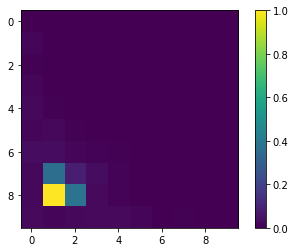

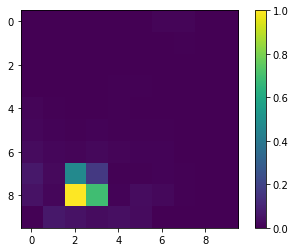

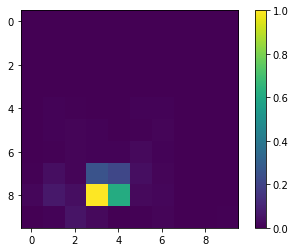

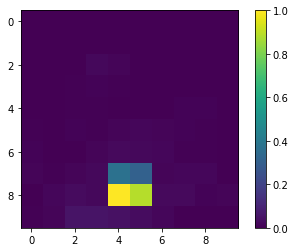

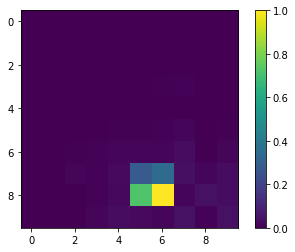

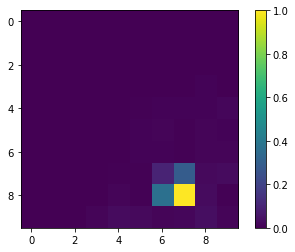

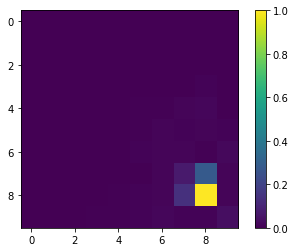

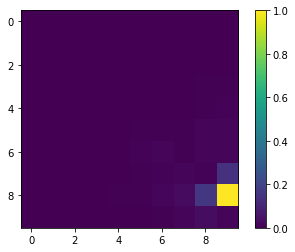

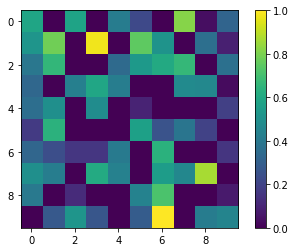

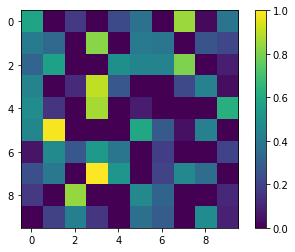

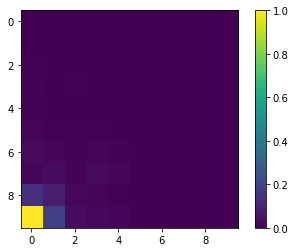

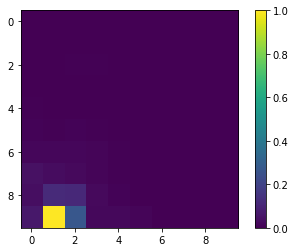

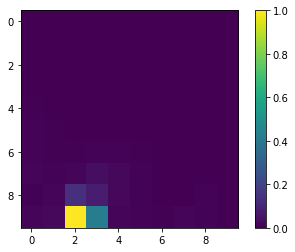

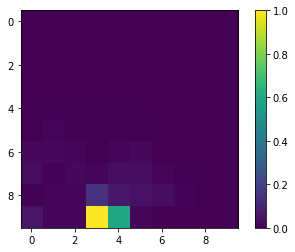

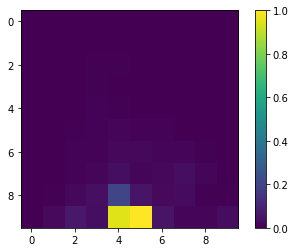

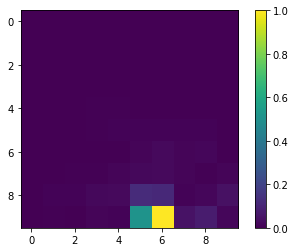

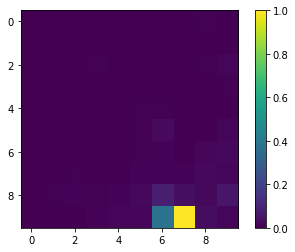

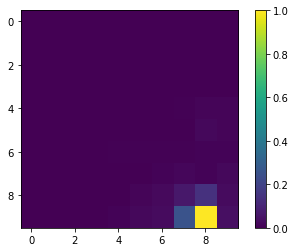

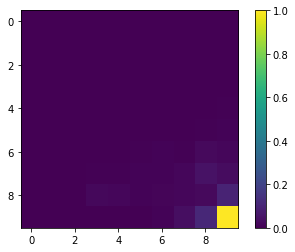

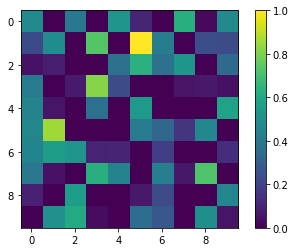

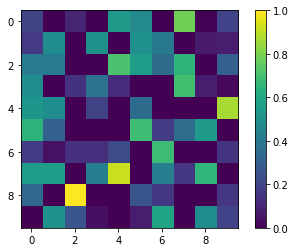

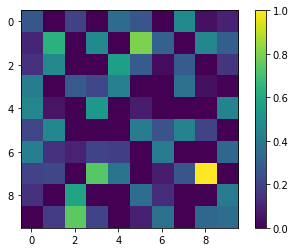

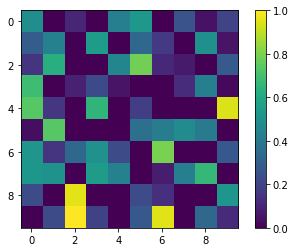

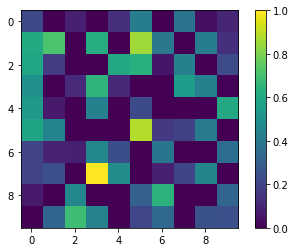

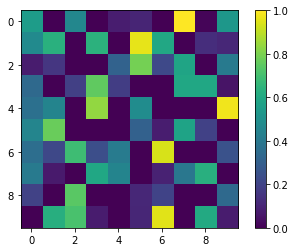

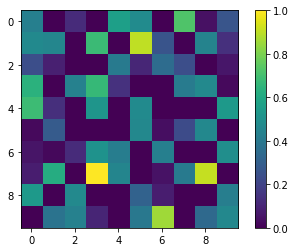

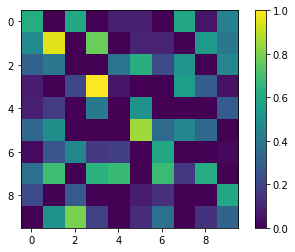

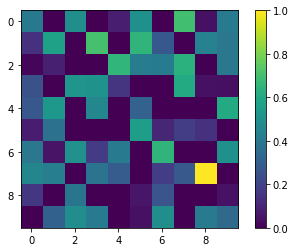

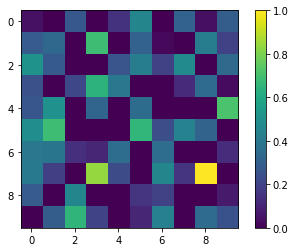

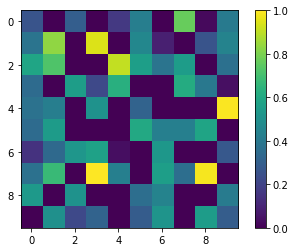

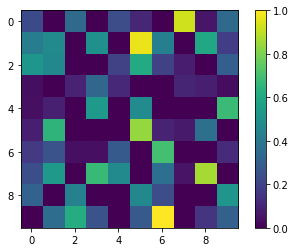

In [166]:
arena_length = int(np.sqrt(input.num_states)) - 1
walk_xs = input.xs.astype(int)
walk_ys = input.ys.astype(int)
for neur in range(outputs.shape[1]):
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.mean(outputs[frame_idxs, neur].numpy())
            firing_field[x,y] = fr
    plt.figure()
    plt.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    plt.colorbar()
    plt.show() 

## Plot columns of M

In [169]:
M = net.ca3.get_M_hat(0.99)

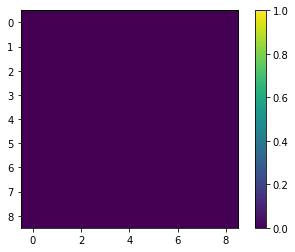

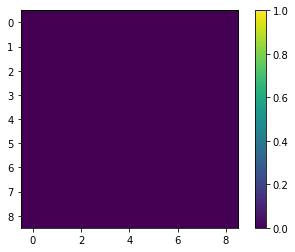

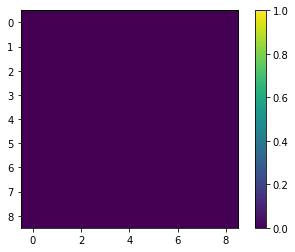

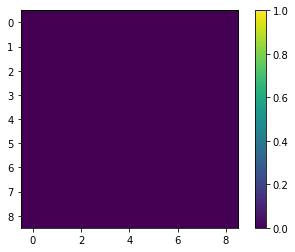

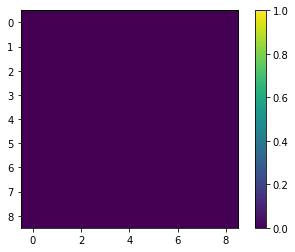

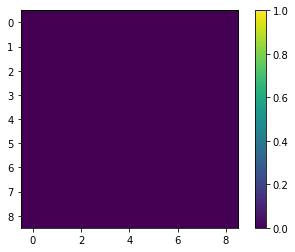

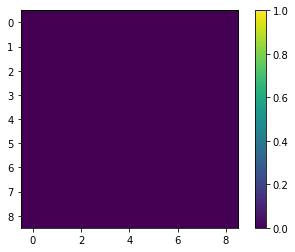

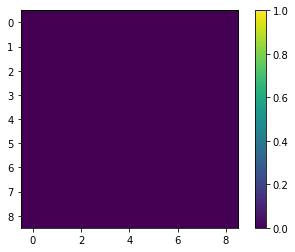

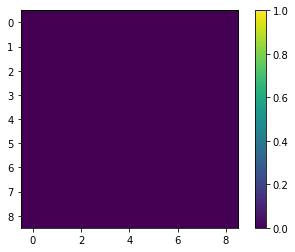

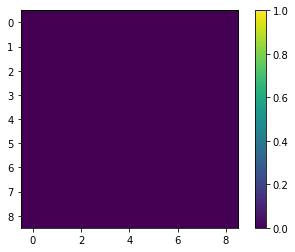

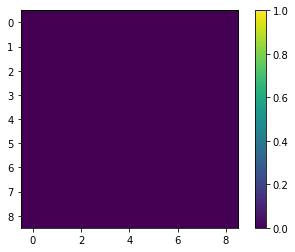

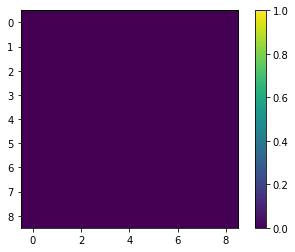

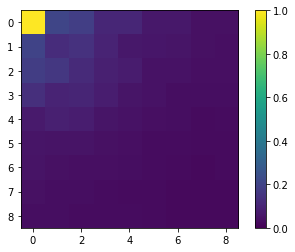

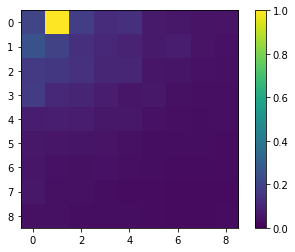

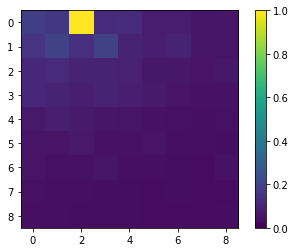

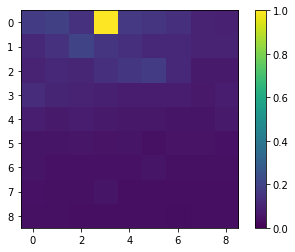

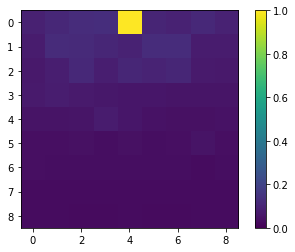

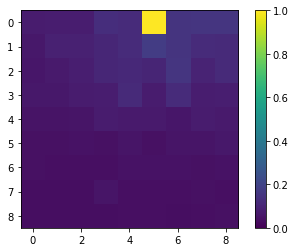

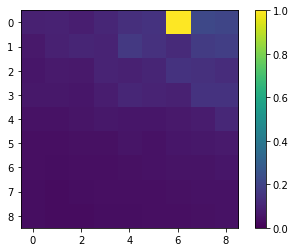

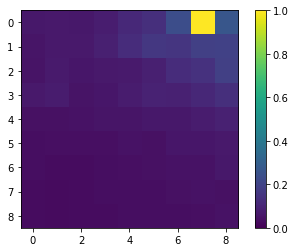

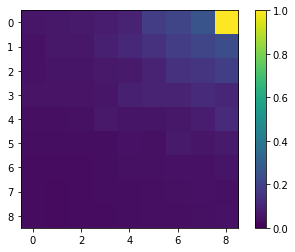

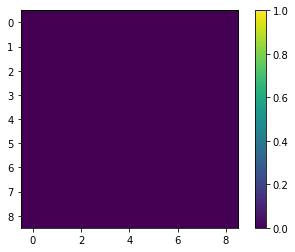

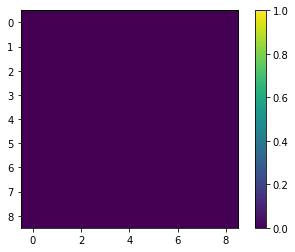

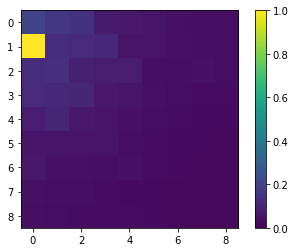

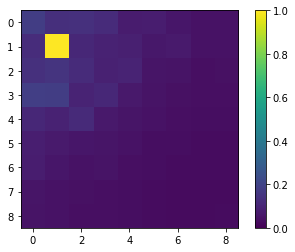

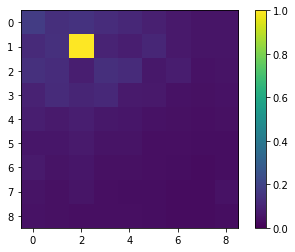

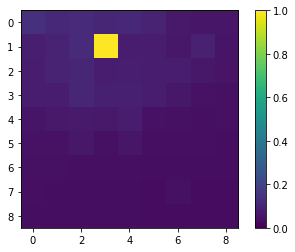

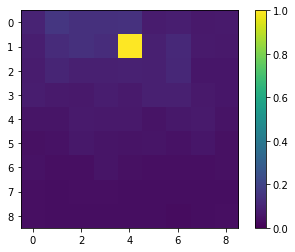

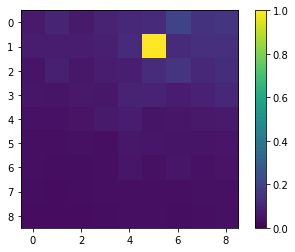

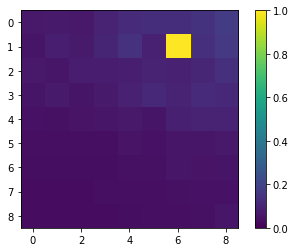

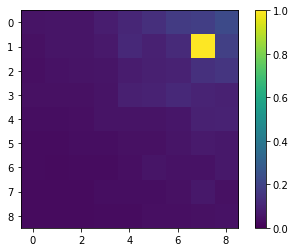

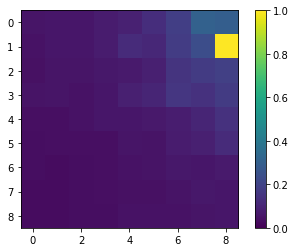

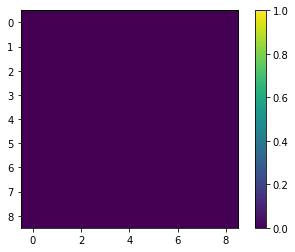

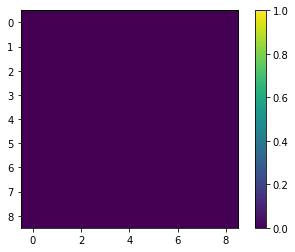

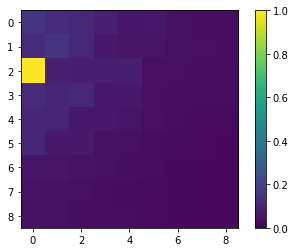

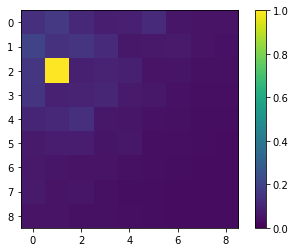

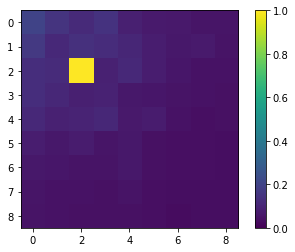

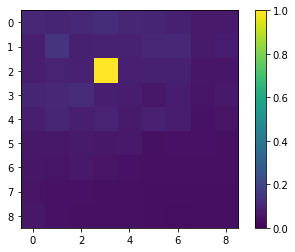

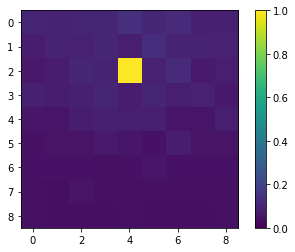

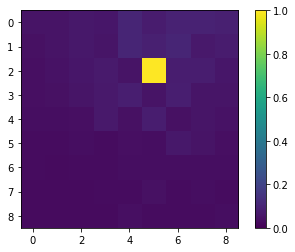

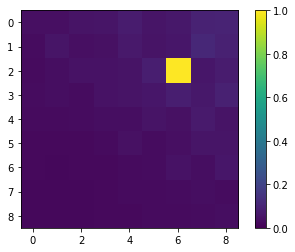

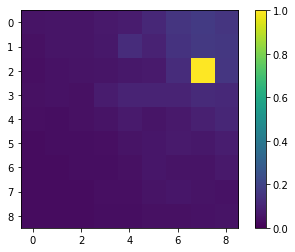

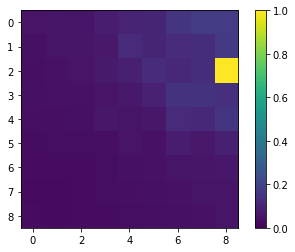

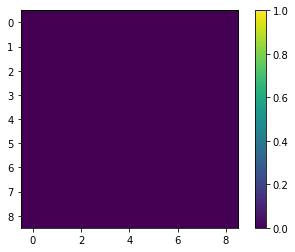

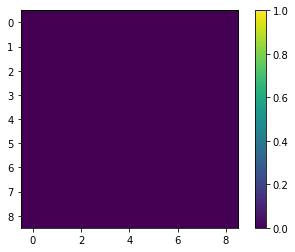

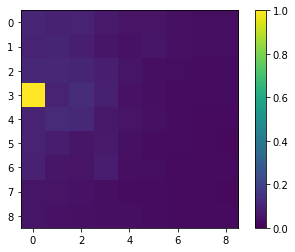

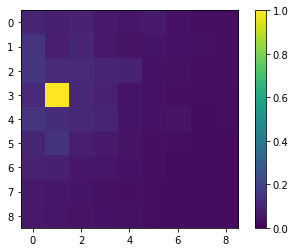

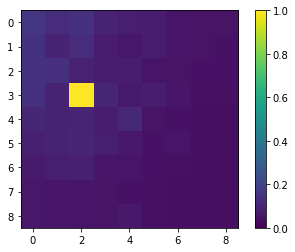

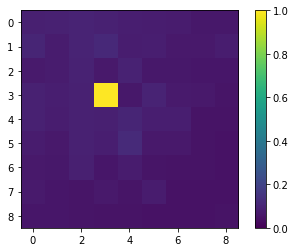

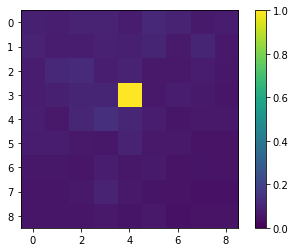

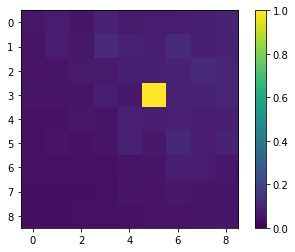

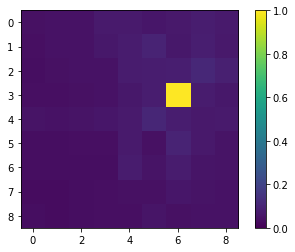

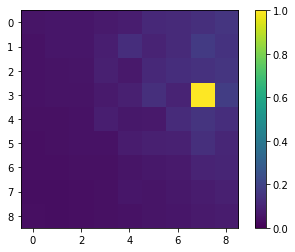

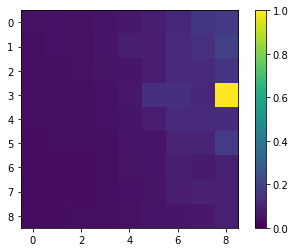

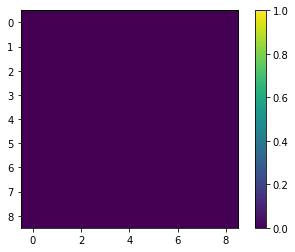

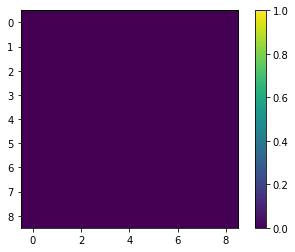

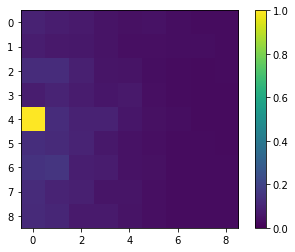

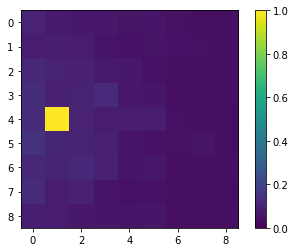

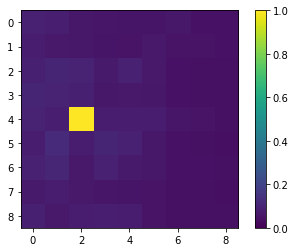

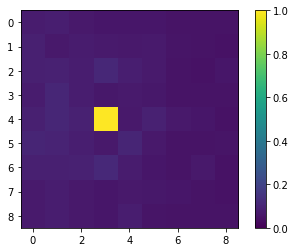

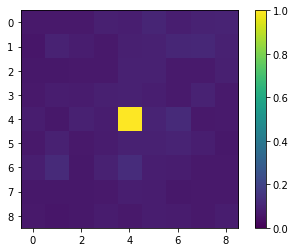

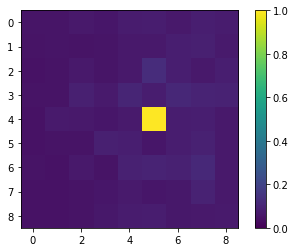

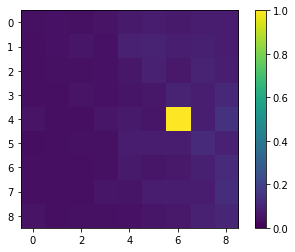

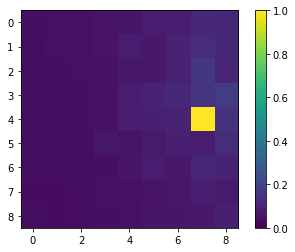

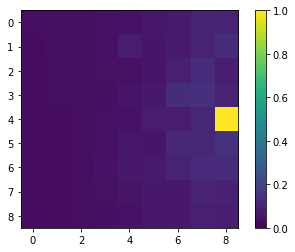

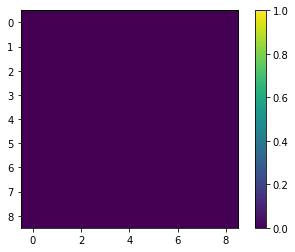

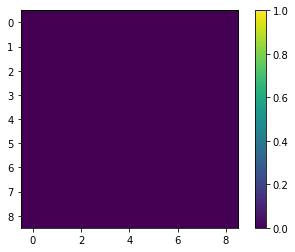

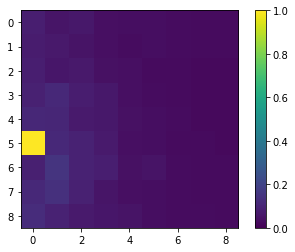

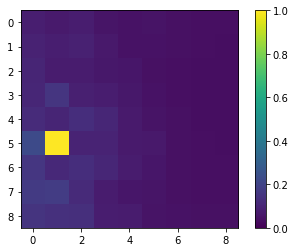

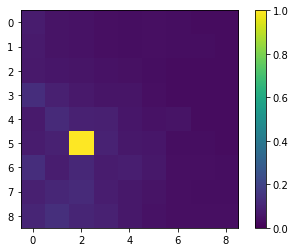

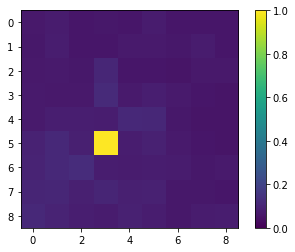

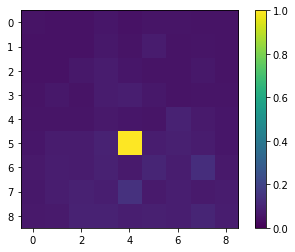

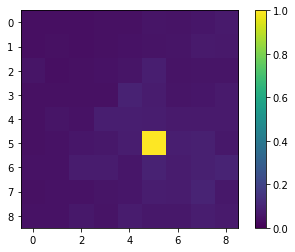

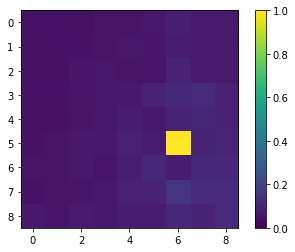

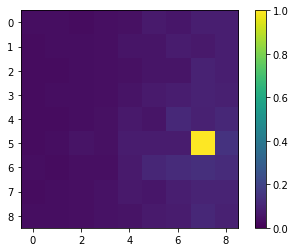

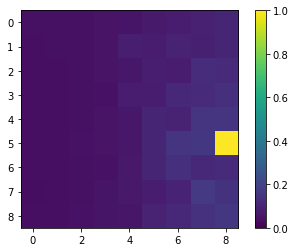

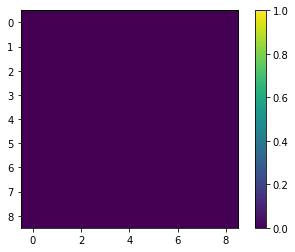

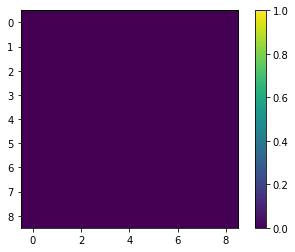

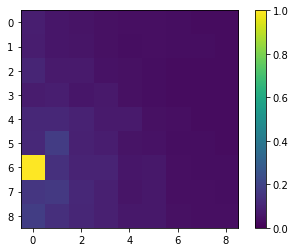

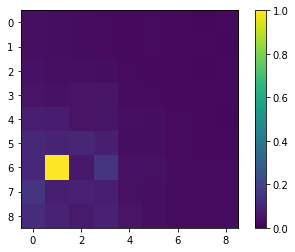

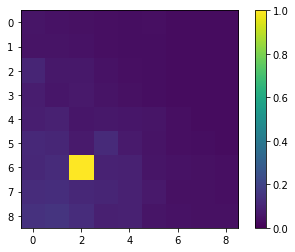

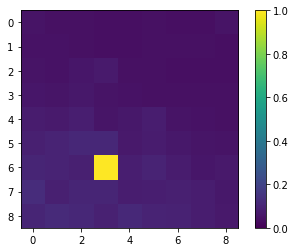

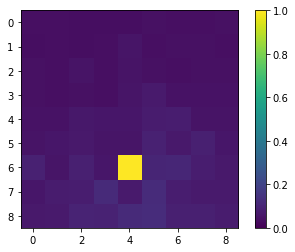

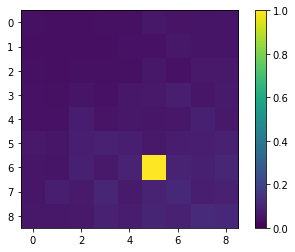

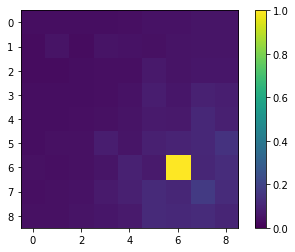

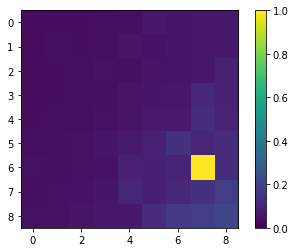

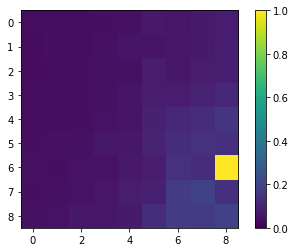

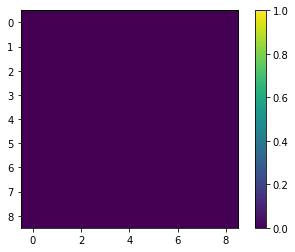

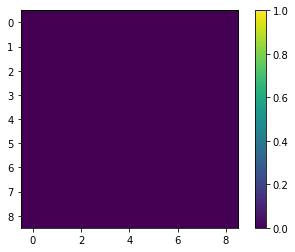

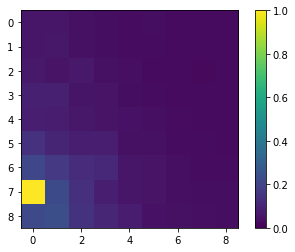

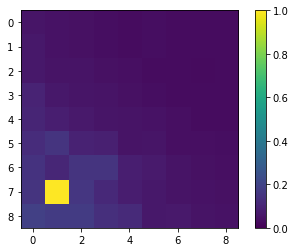

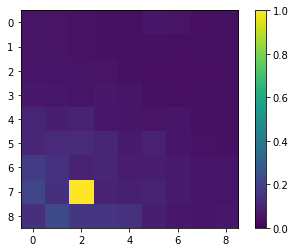

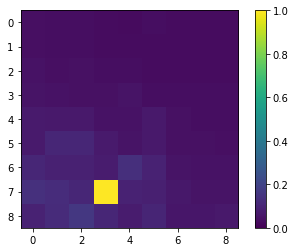

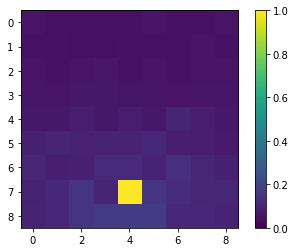

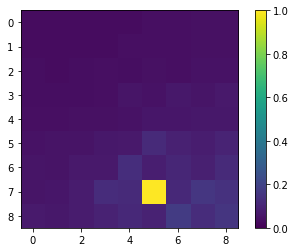

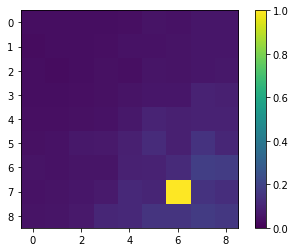

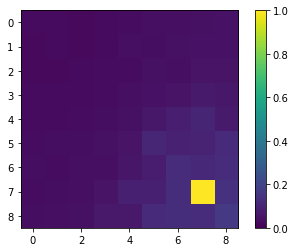

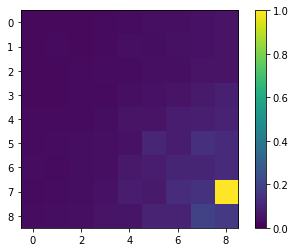

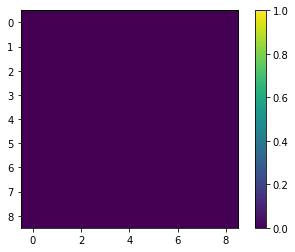

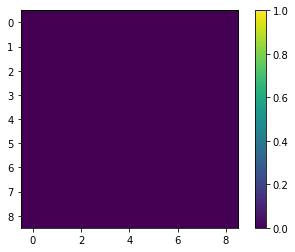

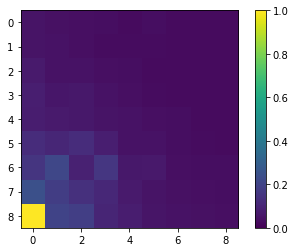

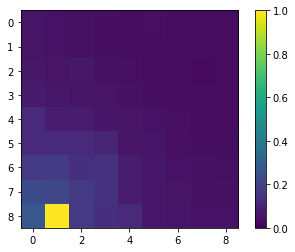

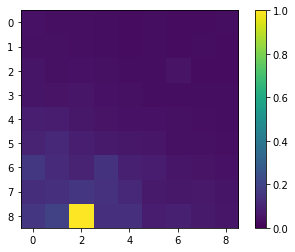

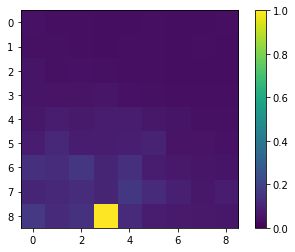

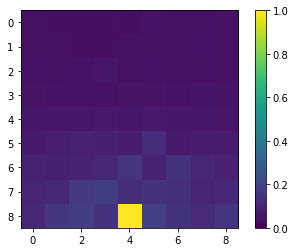

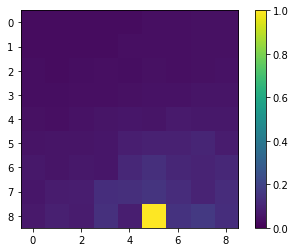

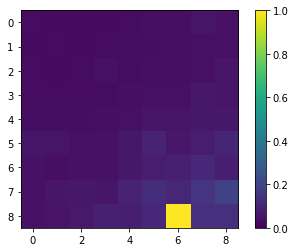

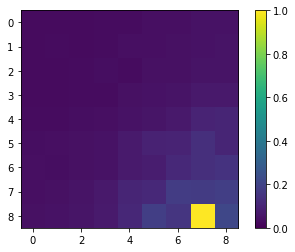

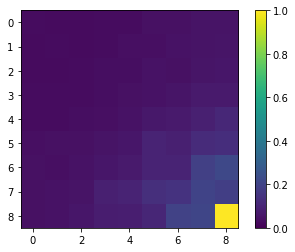

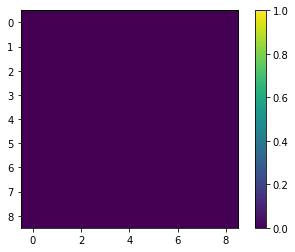

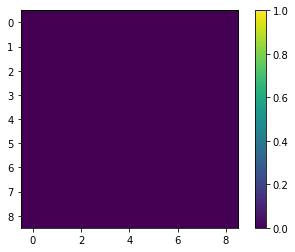

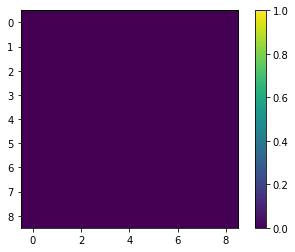

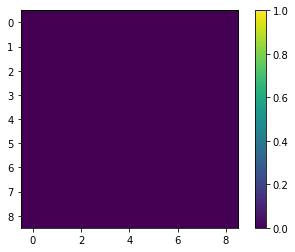

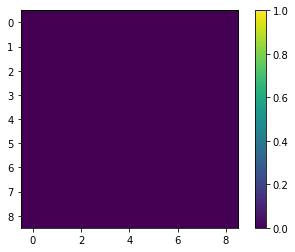

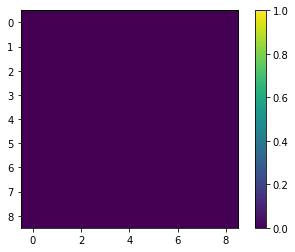

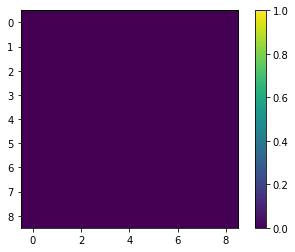

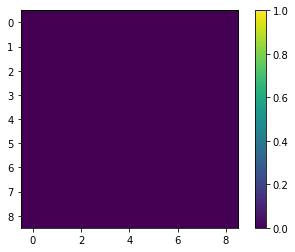

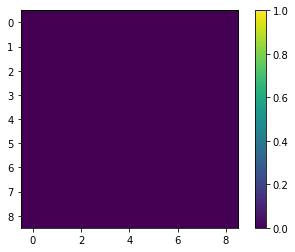

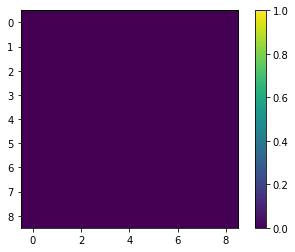

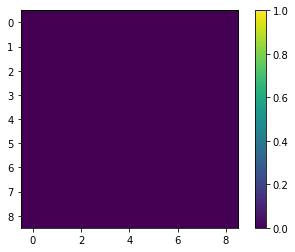

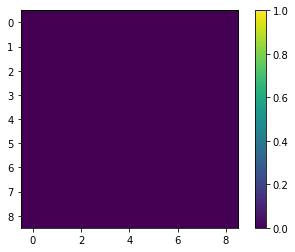

In [170]:
for col in range(M.shape[1]):
    firing_field = M[:,col].detach().numpy()
    num_walls = int(np.sqrt(firing_field.size))
    firing_field =firing_field.reshape((num_walls,num_walls))
    plt.figure()
    plt.imshow(firing_field[1:-1, 1:-1]/firing_field.max(), vmin=0, vmax=1)#[1:-1, 1:-1])
    plt.colorbar()
    plt.show()